In [1]:
import sys; sys.path.append('../')
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from collections import OrderedDict
from loss import compare_activations, get_bre_loss, get_gradmask_loss
import copy
import itertools
import logging
import notebooks.auto_ipynb as auto_ipynb
import numpy as np
import pprint
import random
import time, os, sys
import torch
import torch.nn as nn
import utils.configuration as configuration
import utils.monitoring as monitoring
import models, models.CNN, models.ResNetSmall, models.UNet
import matplotlib.pyplot as plt
import datasets, datasets.MSDDataset
import glob

In [33]:
def render_img(text, i, sample, cnn, resnet, unet, exp_name):
    fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=1, ncols=6,
                                             figsize=(18, 12), dpi=72)
    x, target, use_mask = sample
    
    x_var = torch.autograd.Variable(x[0].unsqueeze(0),
        requires_grad=True)

#     cnn.eval()
#     resnet.eval()
#     unet.eval()

    ax0.set_title(str(i) + " Masked Image")
    img = x[0][0].cpu().numpy()
    img = img / np.max(img)  # Scales the input image so that the maximum=1.
    seg = x[1][0].cpu().numpy() #* 0.5  # Makes mask bright, but not too bright.
    ax0.imshow(img, interpolation='none', cmap='Greys_r')
    ax0.axis('off')
    
    ax1.set_title("Mask")
    ax1.imshow(1-seg, cmap="Greys_r", interpolation='none')
    ax1.axis('off')

    ax2.set_title("CNN")
    y_prime, x_prime = cnn(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, cnn, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    ax2.imshow(np.abs(gradmask), cmap="jet", interpolation='none')
    ax2.axis('off')
    
    ax3.set_title("Resnet")
    y_prime, x_prime = resnet(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, resnet, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    ax3.imshow(np.abs(gradmask), cmap="jet", interpolation='none')
    ax3.axis('off')
    
    ax4.set_title("UNet")
    y_prime, x_prime = unet(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, resnet, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    ax4.imshow(np.abs(gradmask), cmap="jet", interpolation='none')
    ax4.axis('off')

    ax5.set_title("UNet Reconstruction")
    # Fails for models that output a nonsense reconstruction (CNN, ResNet).
    if isinstance(x_prime, torch.Tensor):
        ax5.imshow(x_prime[0][0].detach().cpu().numpy(),
                   interpolation='none', cmap='Greys_r')
        ax5.axis('off')
    else:
        ax5.remove()

    plt.tight_layout()
    plt.show()

In [4]:
glob.glob("/network/tmp1/vivianoj/checkpoints/*resnet/best_model.pth.tar")

['/network/tmp1/vivianoj/checkpoints/cardiacmsd_resnet/best_model.pth.tar',
 '/network/tmp1/vivianoj/checkpoints/livermsd_resnet/best_model.pth.tar',
 '/network/tmp1/vivianoj/checkpoints/synth_resnet/best_model.pth.tar',
 '/network/tmp1/vivianoj/checkpoints/pancreasmsd_resnet/best_model.pth.tar']

In [19]:
toplot = "pancreasmsd"

In [20]:
if toplot == "cardiacmsd":
    d = datasets.MSDDataset.HeartMSDDataset(mode='test', nsamples=10, blur=4)
elif toplot == "livermsd":
    d = datasets.MSDDataset.LiverMSDDataset(mode='test', nsamples=10, blur=4)
elif toplot == "pancreasmsd":
    d = datasets.MSDDataset.PancreasMSDDataset(mode='test', nsamples=10, blur=4)

Full dataset contains: Counter({False: 17929, True: 8790})
mode=test
Loading 113 files:['pancreas_243.nii.gz', 'pancreas_191.nii.gz', 'pancreas_345.nii.gz', 'pancreas_167.nii.gz', 'pancreas_309.nii.gz', 'pancreas_158.nii.gz', 'pancreas_375.nii.gz', 'pancreas_264.nii.gz', 'pancreas_069.nii.gz', 'pancreas_193.nii.gz', 'pancreas_001.nii.gz', 'pancreas_159.nii.gz', 'pancreas_160.nii.gz', 'pancreas_366.nii.gz', 'pancreas_334.nii.gz', 'pancreas_111.nii.gz', 'pancreas_088.nii.gz', 'pancreas_087.nii.gz', 'pancreas_138.nii.gz', 'pancreas_418.nii.gz', 'pancreas_230.nii.gz', 'pancreas_046.nii.gz', 'pancreas_344.nii.gz', 'pancreas_242.nii.gz', 'pancreas_234.nii.gz', 'pancreas_126.nii.gz', 'pancreas_287.nii.gz', 'pancreas_170.nii.gz', 'pancreas_217.nii.gz', 'pancreas_374.nii.gz', 'pancreas_419.nii.gz', 'pancreas_304.nii.gz', 'pancreas_015.nii.gz', 'pancreas_110.nii.gz', 'pancreas_137.nii.gz', 'pancreas_275.nii.gz', 'pancreas_203.nii.gz', 'pancreas_229.nii.gz', 'pancreas_355.nii.gz', 'pancreas_389.n

In [35]:
a= torch.load("/network/tmp1/vivianoj/checkpoints/{}_cnn/best_model.pth.tar".format(toplot), map_location='cpu')
cnn = models.UNet.UNet(img_size=100, nc=64, mode='cnn')
cnn.load_state_dict(a.state_dict())

In [36]:
a= torch.load("/network/tmp1/vivianoj/checkpoints/{}_resnet_actdiff/best_model.pth.tar".format(toplot), map_location='cpu')
resnet = models.ResNetSmall.ResNetSmall(base_size=4608, img_size=100)
resnet.load_state_dict(a.state_dict())

In [37]:
a= torch.load("/network/tmp1/vivianoj/checkpoints/{}_ae/best_model.pth.tar".format(toplot), map_location='cpu')
unet = models.UNet.UNet(img_size=100, nc=64, mode='unet')
#unet.load_state_dict(a.state_dict())

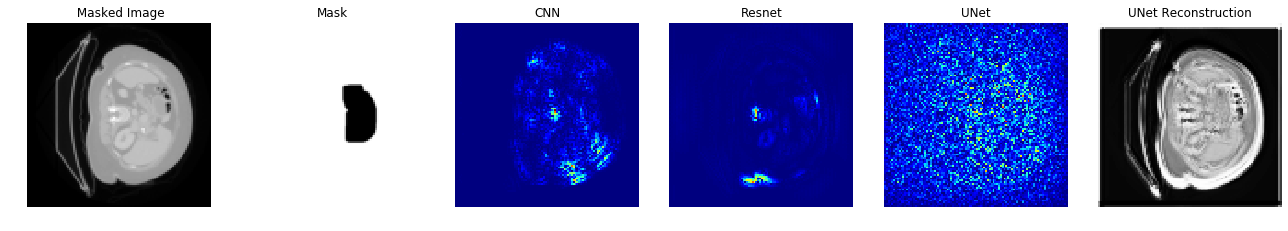

In [38]:
sample = d[0]
render_img("aaa", "", sample, cnn, resnet, unet, "a")